# Генерация маршрутов фестиваля

В предыдущем файле мы провели немного исследований. Из файла с транзакциями вытащили список концертов, сформировали параметры фестиваля, сгруппирвоали и отчистили данные по артистам, авторам и произведениям. Теперь мы можем приступить к генерации маршрутов фестиваля.

## Загрузка отчищенных данных

Сперва мы загрузим все, что нам нужно из файлов с отчищенными на прошлом этапе данных.

In [1]:
import pandas as pd
import datetime

CONCERT_LIST_GOOD = 'data_clean/ConcertList-good.xlsx'
HALLS_TIME_GOOD = 'data_clean/HallsTime-good.xlsx'
FESTDAYS = 'data_clean/fest_days.xlsx'

In [2]:
## Общие данные концертов
concerts = pd.read_excel(CONCERT_LIST_GOOD).set_index('ShowNum')

#преобразуем значение длительнсти концерта в формат времени
concerts['ShowLong'] = pd.to_timedelta(concerts['ShowLong'])
concerts

,ShowId,ShowName,ShowDate,HallName,Genre,ShowLong,Family,Price,Tickets,link
ShowNum,,,,,,,,,,
1,6,Симфонический рояль,2022-07-01 13:00:00,Камерный зал филармонии,Камерные программы,0 days 00:45:00,NaN,200,True,NaN
2,22,Кармен и Пер Гюнт,2022-07-01 13:00:00,Дом музыки,Камерные программы,0 days 00:45:00,1.0,200,True,NaN
3,10,Шопен. Соната и блестящий полонез,2022-07-01 13:30:00,Зал Маклецкого,Камерные программы,0 days 00:45:00,NaN,200,True,NaN
4,14,Шуман и Берлиоз,2022-07-01 13:30:00,ТЮЗ - Большой,Симфонический оркестр,0 days 00:45:00,NaN,200,True,NaN
5,26,Хоровая романтика I,2022-07-01 13:30:00,Камерный театр,Хор,0 days 00:45:00,NaN,200,True,NaN
...,...,...,...,...,...,...,...,...,...,...
96,80,Венеция и Неаполь,2022-07-03 18:00:00,Камерный зал филармонии,Камерные программы,0 days 00:45:00,NaN,200,True,NaN
97,93,Два гобоя и английский рожок,2022-07-03 18:00:00,ТЮЗ - Малый,Камерные программы,0 days 00:45:00,NaN,200,True,NaN
98,90,Фламенко в ритме сердца,2022-07-03 18:45:00,ТЮЗ - Большой,Танец,0 days 00:45:00,NaN,200,True,NaN


In [3]:
## Сетка переходов между залами
HallsTime = pd.read_excel(HALLS_TIME_GOOD).set_index('Unnamed: 0')

# преобразуем время переходов в формат таймдельта
HallsTime = HallsTime.apply(pd.to_timedelta, unit='m')

#HallsTime

In [4]:
FestDays = pd.read_excel(FESTDAYS).set_index('Day')
FestDays

,Start,Finish,Tickets,NumShows
Day,,,,
2022-07-01,13:00,22:15,30,30
2022-07-02,10:00,22:15,39,39
2022-07-03,10:00,20:15,31,31


In [5]:
ShowDetails = pd.read_excel('data_clean/show_details.xlsx').set_index('ShowNum')
ArtistDetails = pd.read_excel('data_clean/ArtistDetails-good.xlsx').set_index('ShowNum')
AuthorStats = pd.read_excel('data_clean/author_stats.xlsx').set_index('Author')
ArtistStats = pd.read_excel('data_clean/artist_stats.xlsx').set_index('Artists')

## Переходим к генерации маршрута

In [6]:
# Сделаем копию данных о концертах для дальнейшей работы
# Это позволит избежать изменений в исходных данных
# и сохранить оригинальные данные для возможного восстановления
GoodShows = concerts.copy()
GoodShows

# вдальнейшем при работе с маршрутами нам понадобятся дополнительные колонки для учета. Добавим их сразу
#GoodShows['TransTime'] = pd.to_timedelta(0, unit='m') #будем хранить время перехода между залами в маршруте
#GoodShows['WaitTime'] = pd.to_timedelta(0, unit='m') #Будем хранить время ожидания между концертами

,ShowId,ShowName,ShowDate,HallName,Genre,ShowLong,Family,Price,Tickets,link
ShowNum,,,,,,,,,,
1,6,Симфонический рояль,2022-07-01 13:00:00,Камерный зал филармонии,Камерные программы,0 days 00:45:00,NaN,200,True,NaN
2,22,Кармен и Пер Гюнт,2022-07-01 13:00:00,Дом музыки,Камерные программы,0 days 00:45:00,1.0,200,True,NaN
3,10,Шопен. Соната и блестящий полонез,2022-07-01 13:30:00,Зал Маклецкого,Камерные программы,0 days 00:45:00,NaN,200,True,NaN
4,14,Шуман и Берлиоз,2022-07-01 13:30:00,ТЮЗ - Большой,Симфонический оркестр,0 days 00:45:00,NaN,200,True,NaN
5,26,Хоровая романтика I,2022-07-01 13:30:00,Камерный театр,Хор,0 days 00:45:00,NaN,200,True,NaN
...,...,...,...,...,...,...,...,...,...,...
96,80,Венеция и Неаполь,2022-07-03 18:00:00,Камерный зал филармонии,Камерные программы,0 days 00:45:00,NaN,200,True,NaN
97,93,Два гобоя и английский рожок,2022-07-03 18:00:00,ТЮЗ - Малый,Камерные программы,0 days 00:45:00,NaN,200,True,NaN
98,90,Фламенко в ритме сердца,2022-07-03 18:45:00,ТЮЗ - Большой,Танец,0 days 00:45:00,NaN,200,True,NaN


### Строим матрицу [не]сочетаемости концертов

Два концерта не могут быть в одном маршруте, если они пересекаются по времени. Пересечение по времени означает, что старт первого концерт + его длительность + время перехода между залами до следующего концерта больше, чем время начала другого концерта.

In [7]:
#возьмем концерты Пока одного дня дня, с которым работаем
OneDayShows = GoodShows[GoodShows['ShowDate'].dt.date.astype(str) == FestDays.index[0].strftime('%Y-%m-%d')]
#OneDayShows = GoodShows.copy()

#на основании индексов = номер концертов этого дня = построим матрицу, в которой будем отмечать сочетаются пары концертов или нет
UnComb = pd.DataFrame(True, index=OneDayShows.index, columns=OneDayShows.index) 

In [8]:
%%time
#сравним каждый концерт с каждым на сочетаемсоть

for i in UnComb.index:
  for j in UnComb.index:
    #время начала концерта + его длительность + время перехода между залами от текущего концерта к следующему
    aaa = OneDayShows.loc[i]['ShowDate'] + OneDayShows.loc[i]['ShowLong'] + HallsTime.loc[OneDayShows.loc[i]['HallName'], OneDayShows.loc[j]['HallName']]

    #время начала концерта, который мы проверяем на сочетаемость
    bbb = OneDayShows.loc[j]['ShowDate']

    #если первое меньше начала второго - тогда концерты сочетаемы = true, иначе false - клиент не сможет и на концерте побыть и до следующего добежать
    if aaa < bbb:
      UnComb.iloc[i-1, j-1] = True
    else:   
      UnComb.iloc[i-1, j-1] = False


#так как таблица симметрична, то отзеркалим значения относительно диагонали (чтобы потом самим не запутаться в индексах)
for j in UnComb.index:
  for i in UnComb.index:
     UnComb.iloc[i-1, j-1] = UnComb.iloc[j-1, i-1]      


UnComb    

CPU times: user 162 ms, sys: 2.39 ms, total: 165 ms
Wall time: 165 ms


ShowNum,1,2,3,4,5,6,7,8,9,10,...,21,22,23,24,25,26,27,28,29,30
ShowNum,,,,,,,,,,,,,,,,,,,,,
1,False,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
2,False,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
3,False,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
4,False,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
5,False,False,False,False,False,False,True,True,True,True,...,True,True,True,True,True,True,True,True,True,True
6,False,False,False,False,False,False,False,True,True,True,...,True,True,True,True,True,True,True,True,True,True
7,True,True,True,True,True,False,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
8,True,True,True,True,True,True,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True
9,True,True,True,True,True,True,False,False,False,False,...,True,True,True,True,True,True,True,True,True,True


### Генерируем комбинации

In [9]:
import itertools #мдуль для комбинаторики
import numpy as np
from typing import List, Tuple

In [10]:
#получим все индексы концертов одного дня
val = OneDayShows.index

#создадим список для хранения хороших маршрутов
GoodRoute = list()

In [11]:
def optimize_incompatibility_matrix(matrix: List[List[bool]]) -> List[set]:
    """
    Преобразует матрицу сочетаемости в список несовместимых индексов.
    Значение False в исходной матрице означает несовместимость.
    """
    return [{j for j, val in enumerate(row) if not val} for row in matrix]

def generate_compatible_routes(val: List[int], N: int, incompat_sets: List[set], index_by_number: dict):
    """
    Ленивая генерация всех совместимых маршрутов длины N.
    val — список номеров концертов (напр. [1, 2, 3, ..., 30])
    """
    for route in itertools.combinations(val, N):
        index_route = [index_by_number[x] for x in route]
        if all(index_route[j] not in incompat_sets[index_route[i]] for i, j in itertools.combinations(range(N), 2)):
            yield route

In [12]:
raw_matrix = UnComb.to_numpy().astype(bool)

# Получение номеров концертов
concert_numbers = val
index_by_number = {num: idx for idx, num in enumerate(concert_numbers)}

# Оптимизация матрицы (True = совместимы, False = конфликт)
incompatibility_sets = optimize_incompatibility_matrix(raw_matrix)

# Доступные концерты (по номерам)
available_concerts = concert_numbers

# Хранение всех маршрутов
all_routes = []

# Перебор по длинам маршрутов
N = 1
while True:
    current_routes = list(generate_compatible_routes(available_concerts, N, incompatibility_sets, index_by_number))
    if not current_routes:
        break

    # Сохраняем в общую переменную
    all_routes.extend(current_routes)

    # Записываем в файл
    output_file = f"compatible_routes_len_{N}.csv"
    with open(output_file, "w") as f:
        f.write(",".join([f"Concert{i+1}" for i in range(N)]) + "\n")
        for route in current_routes:
            f.write(",".join(str(x) for x in route) + "\n")

    print(f"Длина {N}: сохранено {len(current_routes)} маршрутов в файл {output_file}")
    N += 1

print(f"Всего маршрутов найдено: {len(all_routes)}")

Длина 1: сохранено 30 маршрутов в файл compatible_routes_len_1.csv
Длина 2: сохранено 361 маршрутов в файл compatible_routes_len_2.csv
Длина 3: сохранено 2224 маршрутов в файл compatible_routes_len_3.csv
Длина 4: сохранено 7420 маршрутов в файл compatible_routes_len_4.csv
Длина 5: сохранено 13072 маршрутов в файл compatible_routes_len_5.csv
Длина 6: сохранено 11043 маршрутов в файл compatible_routes_len_6.csv
Длина 7: сохранено 3524 маршрутов в файл compatible_routes_len_7.csv
Длина 8: сохранено 272 маршрутов в файл compatible_routes_len_8.csv
Всего маршрутов найдено: 37946


## Введем арактеристики маршрутов

 На предыдущем этапе мы получили длинный список маршрутов, которые проверили на адекватность и соотносимость с реальностью. Теперь каждому оставшемуся маршруту присвоим какие то оценивающие характеристики, чтобы можно было их ранжировать: полнота залов, жанров, исполниетлей произведений, звезд и чего угодно еще

In [13]:
#соберем структуру для хранения оценок маршрутов
RouteRange = pd.DataFrame(index=range(0, len(GoodRoute)))

RouteRange['Sostav'] = np.nan #создадим колонку, где будем отображать лист с номерами концертов

RouteRange['Days'] = 0 #создадим колонку для учета количества дней маршрута
RouteRange['Concerts'] = 0 #создадим колонку для учета количества концертов маршрута

#RouteRange['RouteStart'] = 0 #время начала маршрута
#RouteRange['RouteFinish'] = 0 #время окончания маршрута

RouteRange['Halls'] = 0 #создадим колонку для учета разнообразия залов маршрута
RouteRange['Genre'] = 0 #создадим колонку для учета разнообразия жанров маршрута
RouteRange['NumTopAuthor'] = 0 #jсздадим колонку для учета количества топовых авторов в маршруте
RouteRange['ShowTime'] = 0 #создадим колонку для учета длительности всех концертов маршрута
RouteRange['TransTime'] = 0 #создадим колонку для учета длительности переходов между залами всех концертов маршрута
RouteRange['WaitTime'] = 0 #создадим колонку для учета времени ожидания между концом одного концерта и началом другого (без времени перехода)
RouteRange['Costs'] = 0 #создадим колонку для учета стоимости всех концертов маршрута

RouteRange['Musician'] = 0 #создадим колонку для учета количества музыкантов маршрута
RouteRange['Composer'] = 0 #создадим колонку для учета количества композиторов маршрута
RouteRange['programm'] = 0 #создадим колонку для учета произведений маршрута

RouteRange['FamilyConc'] = 0 #создадим колонку для учета семейных концертов

In [14]:
#создадим матрицу для учета употребления композиторов в том или ином маршруте
#RouteAuthors = pd.DataFrame(index=RouteRange.index, columns=AuthorStats.index)

#создадим матрицу для учета употребления артистов в том или ином маршруте
#RouteSpetialArtist = pd.DataFrame(index=RouteRange.index, columns=ArtistStats.index)



In [15]:
# Функция для анализа маршрута, которая размечает его характеристики
def analyze_route(route_ids, i, GoodShows_indexed, ShowDetails_indexed, ArtistDetails_indexed,
                  HallsTime, RouteRange, RouteAuthors, RouteSpetialArtist):
    route_ids = list(route_ids) 
    route_shows = GoodShows_indexed.loc[route_ids]
    show_details = ShowDetails_indexed.loc[route_ids]
    artist_details = ArtistDetails_indexed.loc[route_ids]

    RouteRange.at[i, 'Sostav'] = route_ids
    RouteRange.at[i, 'Days'] = pd.Series(route_shows['ShowDate']).dt.date.nunique()
    RouteRange.at[i, 'Concerts'] = len(route_ids)
    RouteRange.at[i, 'Halls'] = route_shows['HallName'].nunique()
    RouteRange.at[i, 'Genre'] = route_shows['Genre'].nunique()
    RouteRange.at[i, 'ShowTime'] = route_shows['ShowLong'].sum()
    RouteRange.at[i, 'Costs'] = route_shows['Price'].sum()
    RouteRange.at[i, 'Musician'] = artist_details['Artists'].nunique()
    RouteRange.at[i, 'Composer'] = show_details['Author'].nunique()
    RouteRange.at[i, 'programm'] = show_details['Programm'].nunique()
    RouteRange.at[i, 'FamilyConc'] = route_shows['Family'].sum()

    halls = route_shows['HallName'].reset_index(drop=True)
    trans_times = sum(
        (HallsTime[halls.iloc[j]][halls.iloc[j+1]] for j in range(len(halls) - 1)),
        pd.to_timedelta(0)
    )
    RouteRange.at[i, 'TransTime'] = trans_times

    start_times = route_shows['ShowDate'].reset_index(drop=True)
    durations = route_shows['ShowLong'].reset_index(drop=True)
    waits = start_times.shift(-1) - (start_times + durations)
    RouteRange.at[i, 'WaitTime'] = waits[:-1].sum()

    authors = show_details['Author'].value_counts()
    RouteAuthors.loc[i, authors.index] = authors.values

    artists = artist_details['Artists'].value_counts()
    RouteSpetialArtist.loc[i, artists.index] = artists.values


In [16]:

num_routes = len(GoodRoute)

# Индексируем данные
GoodShows_indexed = GoodShows
ShowDetails_indexed = ShowDetails
ArtistDetails_indexed = ArtistDetails

GoodRoute = all_routes.copy()
num_routes = len(GoodRoute)

RouteRange = pd.DataFrame({
    'Sostav': [None] * num_routes,
    'Days': [0] * num_routes,
    'Concerts': [0] * num_routes,
    'Halls': [0] * num_routes,
    'Genre': [0] * num_routes,
    'ShowTime': [0] * num_routes,
    'TransTime': [pd.to_timedelta(0)] * num_routes,
    'WaitTime': [pd.to_timedelta(0)] * num_routes,
    'Costs': [0] * num_routes,
    'Musician': [0] * num_routes,
    'Composer': [0] * num_routes,
    'programm': [0] * num_routes,
    'FamilyConc': [0] * num_routes,
}, index=range(num_routes))

# Дополнительные таблицы для авторов и артистов
RouteAuthors = pd.DataFrame(0, index=range(num_routes), columns=AuthorStats.index)
RouteSpetialArtist = pd.DataFrame(0, index=range(num_routes), columns=ArtistStats.index)

# Обработка маршрутов
for i, route in enumerate(GoodRoute):
    if i % 1000 == 0:
        print(f"Обработка маршрута {i}/{num_routes}")
    analyze_route(route, i, GoodShows_indexed, ShowDetails_indexed, ArtistDetails_indexed,
                  HallsTime, RouteRange, RouteAuthors, RouteSpetialArtist)
    

    # Пример сохранения
#RouteRange.to_csv("RouteRange.csv", index=False)
#RouteAuthors.to_csv("RouteAuthors.csv")
#RouteSpetialArtist.to_csv("RouteSpetialArtist.csv")

Обработка маршрута 0/37946


/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/1087394813.py:14: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '0 days 00:45:00' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  RouteRange.at[i, 'ShowTime'] = route_shows['ShowLong'].sum()


Обработка маршрута 1000/37946
Обработка маршрута 2000/37946
Обработка маршрута 3000/37946
Обработка маршрута 4000/37946
Обработка маршрута 5000/37946
Обработка маршрута 6000/37946
Обработка маршрута 7000/37946
Обработка маршрута 8000/37946
Обработка маршрута 9000/37946
Обработка маршрута 10000/37946
Обработка маршрута 11000/37946
Обработка маршрута 12000/37946
Обработка маршрута 13000/37946
Обработка маршрута 14000/37946
Обработка маршрута 15000/37946
Обработка маршрута 16000/37946
Обработка маршрута 17000/37946
Обработка маршрута 18000/37946
Обработка маршрута 19000/37946
Обработка маршрута 20000/37946
Обработка маршрута 21000/37946
Обработка маршрута 22000/37946
Обработка маршрута 23000/37946
Обработка маршрута 24000/37946
Обработка маршрута 25000/37946
Обработка маршрута 26000/37946
Обработка маршрута 27000/37946
Обработка маршрута 28000/37946
Обработка маршрута 29000/37946
Обработка маршрута 30000/37946
Обработка маршрута 31000/37946
Обработка маршрута 32000/37946
Обработка маршрут

In [17]:
# Преобразуем строки или объекты в timedelta
RouteRange['TransTime'] = pd.to_timedelta(RouteRange['TransTime'], errors='coerce')
RouteRange['WaitTime'] = pd.to_timedelta(RouteRange['WaitTime'], errors='coerce')
RouteRange['ShowTime'] = pd.to_timedelta(RouteRange['ShowTime'], errors='coerce')

# Переводим в минуты (float)
RouteRange['TransTime'] = RouteRange['TransTime'].dt.total_seconds() / 60
RouteRange['WaitTime'] = RouteRange['WaitTime'].dt.total_seconds() / 60
RouteRange['ShowTime'] = RouteRange['ShowTime'].dt.total_seconds() / 60


In [18]:
RouteRange

,Sostav,Days,Concerts,Halls,Genre,ShowTime,TransTime,WaitTime,Costs,Musician,Composer,programm,FamilyConc
0,[1],1,1,1,1,45.0,0.0,0.0,200,1,1,2,0
1,[2],1,1,1,1,45.0,0.0,0.0,200,1,6,6,1
2,[3],1,1,1,1,45.0,0.0,0.0,200,2,2,3,0
3,[4],1,1,1,1,45.0,0.0,0.0,200,3,2,2,0
4,[5],1,1,1,1,45.0,0.0,0.0,200,2,4,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
37941,"[6, 9, 13, 16, 20, 24, 28, 30]",1,8,5,5,390.0,68.0,165.0,1600,13,15,28,0
37942,"[6, 9, 13, 16, 21, 23, 28, 30]",1,8,4,6,390.0,60.0,165.0,1600,12,14,29,0
37943,"[6, 9, 13, 16, 21, 24, 28, 30]",1,8,5,5,390.0,64.0,165.0,1600,12,14,30,0
37944,"[6, 9, 13, 17, 21, 23, 28, 30]",1,8,5,5,395.0,56.0,160.0,1600,12,11,22,0


In [19]:
#Оценим среднее время ожидания для маршрута из N концертов и среднее время переходов
RouteTimeNorm = RouteRange.groupby('Concerts')[['TransTime', 'WaitTime']].agg(['mean','min','max'])
RouteTimeNorm

TransTime                WaitTime              
               mean   min   max        mean    min    max
Concerts                                                 
1          0.000000   0.0   0.0    0.000000    0.0    0.0
2          5.653740   0.0  14.0  168.614958    5.0  510.0
3         11.375899   0.0  27.0  232.066097   20.0  465.0
4         17.204313   0.0  40.0  254.620620   35.0  420.0
5         23.247935   0.0  53.0  256.820303   50.0  375.0
6         29.695644   0.0  64.0  245.939056   80.0  330.0
7         37.196084   9.0  75.0  222.241771   95.0  285.0
8         47.007353  23.0  74.0  194.963235  125.0  230.0

### Дополнительные характеристики по времени 

Теперь у нас есть цель сравнить маршруты одинаковой длины по тому, насколько они эффективны по времени, и выразить это в виде интерпретируемых метрик, например:

«Этот маршрут лучше, чем 87% других маршрутов такой же длины по времени переходов».

*🧱 Что делает функция ниже*
1.Преобразует время переходов и ожиданий в минуты
Столбцы TransTime и WaitTime (тип timedelta) преобразуются в значения в минутах (TransTime_min, WaitTime_min), чтобы их можно было сравнивать.

2. Группирует маршруты по количеству концертов (Concerts)
Это важно: маршруты сравниваются только среди тех, у кого одинаковая длина.

3. Считает ранги (процентили)
Для каждого маршрута определяется, в каком проценте худших маршрутов он находится по каждой из временных метрик:

* TransTime_% — процент маршрутов с меньшим временем перехода

* WaitTime_% — процент маршрутов с меньшим временем ожидания

4.Инвертирует значения, чтобы "меньше = лучше"
Мы хотим, чтобы высокая оценка означала эффективность, поэтому:

* TransTime_Score = 100 - TransTime_%

* WaitTime_Score = 100 - WaitTime_%

Теперь 90% означает: лучше, чем 90% других маршрутов той же длины.

5. Вычисляет интегральную метрику "взвешенной эффективности"
Trans-Wait_% = TransTime_Score * WaitTime_Score / 100
Это приближённая модель, в которой оба фактора одинаково важны, и плохой показатель по одному из них тянет итог вниз.



In [20]:
import pandas as pd

def add_relative_time_metrics(RouteRange: pd.DataFrame):
    """
    Добавляет к RouteRange нормализованные метрики по TransTime и WaitTime
    и вычисляет итоговую интегральную метрику Trans-Wait_%.
    """

    # # Убедимся, что TransTime и WaitTime в формате timedelta
    # RouteRange['TransTime'] = pd.to_timedelta(RouteRange['TransTime'])
    # RouteRange['WaitTime'] = pd.to_timedelta(RouteRange['WaitTime'])

    # # Преобразуем в минуты
    # RouteRange['TransTime_min'] = RouteRange['TransTime'].dt.total_seconds() / 60
    # RouteRange['WaitTime_min'] = RouteRange['WaitTime'].dt.total_seconds() / 60

    # Нормализуем ранги внутри каждой группы длины маршрута (Concerts)
    RouteRange['TransTime_%'] = (
        RouteRange.groupby('Concerts')['TransTime']
        .rank(pct=True) * 100
    ).round(1)

    RouteRange['WaitTime_%'] = (
        RouteRange.groupby('Concerts')['WaitTime']
        .rank(pct=True) * 100
    ).round(1)

    # Инверсия: меньше — лучше
    RouteRange['TransTime_Score'] = 100 - RouteRange['TransTime_%']
    RouteRange['WaitTime_Score'] = 100 - RouteRange['WaitTime_%']

    # Интегральная метрика: произведение двух нормализованных величин
    RouteRange['Trans-Wait_%'] = (
        RouteRange['TransTime_Score'] * RouteRange['WaitTime_Score'] / 100
    ).round(1)

    return RouteRange


In [21]:
RouteRange = add_relative_time_metrics(RouteRange)
RouteRange

,Sostav,Days,Concerts,Halls,Genre,ShowTime,TransTime,WaitTime,Costs,Musician,Composer,programm,FamilyConc,TransTime_%,WaitTime_%,TransTime_Score,WaitTime_Score,Trans-Wait_%
0,[1],1,1,1,1,45.0,0.0,0.0,200,1,1,2,0,51.7,51.7,48.3,48.3,23.3
1,[2],1,1,1,1,45.0,0.0,0.0,200,1,6,6,1,51.7,51.7,48.3,48.3,23.3
2,[3],1,1,1,1,45.0,0.0,0.0,200,2,2,3,0,51.7,51.7,48.3,48.3,23.3
3,[4],1,1,1,1,45.0,0.0,0.0,200,3,2,2,0,51.7,51.7,48.3,48.3,23.3
4,[5],1,1,1,1,45.0,0.0,0.0,200,2,4,4,0,51.7,51.7,48.3,48.3,23.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37941,"[6, 9, 13, 16, 20, 24, 28, 30]",1,8,5,5,390.0,68.0,165.0,1600,13,15,28,0,97.6,10.5,2.4,89.5,2.1
37942,"[6, 9, 13, 16, 21, 23, 28, 30]",1,8,4,6,390.0,60.0,165.0,1600,12,14,29,0,87.9,10.5,12.1,89.5,10.8
37943,"[6, 9, 13, 16, 21, 24, 28, 30]",1,8,5,5,390.0,64.0,165.0,1600,12,14,30,0,95.2,10.5,4.8,89.5,4.3
37944,"[6, 9, 13, 17, 21, 23, 28, 30]",1,8,5,5,395.0,56.0,160.0,1600,12,11,22,0,80.3,8.3,19.7,91.7,18.1


### Добавим еще комплексных метрик

Density — плотность маршрута (время концертов / длительность маршрута в минутах)

HallChanges — количество смен залов

Top5Authors — количество произведений от авторов из ТОП-5 по фестивалю

In [22]:
def add_additional_metrics(RouteRange: pd.DataFrame,
                           GoodShows_indexed: pd.DataFrame,
                           ShowDetails_indexed: pd.DataFrame,
                           ArtistDetails_indexed: pd.DataFrame,
                           top5_authors: set,
                           rare_authors: set) -> pd.DataFrame:
    """
    Добавляет в RouteRange:
    1. Плотность маршрута (ShowTime / span маршрута)
    2. Кол-во смен залов
    3. Кол-во и доля произведений от ТОП-5 авторов
    """

    RouteRange['Density'] = 0.0
    RouteRange['HallChanges'] = 0
    RouteRange['Top5Authors'] = 0
    RouteRange['Top5AuthorsShare'] = 0.0

    for i, route in RouteRange['Sostav'].items():
        if not isinstance(route, (list, tuple, pd.Series)):
            continue

        route = list(route)
        shows = GoodShows_indexed.loc[route]
        show_details = ShowDetails_indexed.loc[route]
        artist_details = ArtistDetails_indexed.loc[route]

        # Плотность маршрута
        start_time = shows['ShowDate'].min()
        end_time = shows['ShowDate'].max()
        duration = (end_time - start_time).total_seconds() / 60  # мин

        if duration > 0:
            show_time = pd.to_timedelta(RouteRange.at[i, 'ShowTime']).total_seconds() / 60
            RouteRange.at[i, 'Density'] = round(show_time / duration, 3)

        # Кол-во смен залов
        halls = shows['HallName'].tolist()
        changes = sum(halls[j] != halls[j + 1] for j in range(len(halls) - 1))
        RouteRange.at[i, 'HallChanges'] = changes

        # Подсчёт произведений от ТОП-5 авторов
        authors_raw = show_details['Author'].dropna().tolist()
        top_author_count = sum(1 for a in authors_raw if a in top5_authors)
        RouteRange.at[i, 'Top5Authors'] = top_author_count
        RouteRange.at[i, 'Top5AuthorsShare'] = round(top_author_count / len(authors_raw), 3) if authors_raw else 0.0


        # Подсчет доли редких авторов
        authors_raw = show_details['Author'].dropna().tolist()

        rare_author_count = sum(1 for a in authors_raw if a in rare_authors)
        RouteRange.at[i, 'RareAuthorsShare'] = round(rare_author_count / len(authors_raw), 3) if authors_raw else 0.0

        # Подсчёт рекомендованных артистов
        if 'Spetial' in artist_details.columns:
            spetial_flags = artist_details['Spetial'].fillna(False)
            recommended_artist_count = spetial_flags.sum()
            RouteRange.at[i, 'RecommendedArtistsRatio'] = round(recommended_artist_count / len(spetial_flags), 3) if len(spetial_flags) else 0.0
        else:
            RouteRange.at[i, 'RecommendedArtistsRatio'] = 0.0

        # Подсчёт рекомендованных произведений
        if 'Spetial' in show_details.columns:
            spetial_flags = show_details['Spetial'].fillna(False)
            recommended_piece_count = spetial_flags.sum()
            RouteRange.at[i, 'RecommendedPiecesRatio'] = round(recommended_piece_count / len(spetial_flags), 3) if len(spetial_flags) else 0.0
        else:
            RouteRange.at[i, 'RecommendedPiecesRatio'] = 0.0




    return RouteRange


In [23]:
# посчитаем топ-5 авторов по количеству концертов
top5_authors = set(AuthorStats['Programm'].nlargest(5).index)
# посчитаем редких авторов по количеству концертов
rare_authors = set(AuthorStats['Programm'].nsmallest(5).index)


# Получим новые метрики
RouteRange = add_additional_metrics(RouteRange, GoodShows_indexed, ShowDetails_indexed, ArtistDetails_indexed,top5_authors, rare_authors)


In [24]:
RouteRange[RouteRange['Top5Authors'] == 5]

,Sostav,Days,Concerts,Halls,Genre,ShowTime,TransTime,WaitTime,Costs,Musician,...,TransTime_Score,WaitTime_Score,Trans-Wait_%,Density,HallChanges,Top5Authors,Top5AuthorsShare,RareAuthorsShare,RecommendedArtistsRatio,RecommendedPiecesRatio
35,"[1, 12]",1,2,2,1,90.0,7.0,120.0,400,3,...,37.1,58.4,21.7,0.0,1,5,0.556,0.111,0.000,0.0
37,"[1, 14]",1,2,2,1,90.0,7.0,165.0,400,2,...,37.1,44.9,16.7,0.0,1,5,0.625,0.000,0.500,0.0
41,"[1, 18]",1,2,2,2,95.0,0.0,225.0,400,4,...,92.0,28.9,26.6,0.0,1,5,1.000,0.000,0.500,0.0
47,"[1, 24]",1,2,2,1,90.0,1.0,345.0,400,3,...,77.6,8.7,6.8,0.0,1,5,1.000,0.000,0.333,0.0
50,"[1, 27]",1,2,2,2,90.0,6.0,375.0,400,2,...,58.4,5.3,3.1,0.0,1,5,0.625,0.000,0.500,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30935,"[5, 7, 13, 20, 26, 29]",1,6,4,4,345.0,30.0,225.0,1200,12,...,47.3,60.7,28.7,0.0,4,5,0.500,0.100,0.615,0.0
33610,"[7, 11, 17, 22, 25, 29]",1,6,5,2,360.0,11.0,150.0,1200,15,...,98.3,94.6,93.0,0.0,5,5,0.625,0.125,0.500,0.0
33624,"[7, 11, 19, 22, 25, 29]",1,6,5,2,355.0,23.0,155.0,1200,14,...,75.4,93.3,70.3,0.0,5,5,0.312,0.062,0.533,0.0
33803,"[7, 13, 17, 22, 25, 29]",1,6,6,3,360.0,16.0,150.0,1200,14,...,92.3,94.6,87.3,0.0,5,5,0.625,0.000,0.533,0.0


### Комфортность маршрута

Метрика ComfortScore — это интегральный показатель удобства маршрута, рассчитанный как взвешенное среднее из:

* TransTime_Score — насколько хорош маршрут по времени переходов между залами

* WaitTime_Score — насколько хорош маршрут по времени ожидания между 

ComfortScore = 0.7 * TransTime_Score + 0.3 * WaitTime_Score

Оба компонента уже приведены к шкале от 0 до 100, где 100 — идеал, 0 — максимум дискомфорта

Итоговая метрика тоже от 0 до 100, где:

* ComfortScore = 100 — маршрут идеален по времени

* ComfortScore = 50 — средний уровень комфорта

* ComfortScore < 30 — потенциально утомительный или неудобный маршрут

In [25]:
def add_comfort_score(RouteRange: pd.DataFrame, trans_weight: float = 0.7, wait_weight: float = 0.3) -> pd.DataFrame:
    """
    Добавляет в RouteRange интегральную метрику ComfortScore — взвешенное среднее из TransTime_Score и WaitTime_Score.
    Оба значения должны быть рассчитаны заранее.

    :param RouteRange: DataFrame с маршрутами
    :param trans_weight: вес времени переходов
    :param wait_weight: вес времени ожидания
    :return: обновлённый DataFrame с колонкой ComfortScore
    """
    RouteRange['ComfortScore'] = (
        trans_weight * RouteRange['TransTime_Score'] +
        wait_weight * RouteRange['WaitTime_Score']
    ).round(1)

    return RouteRange


In [26]:
RouteRange = add_comfort_score(RouteRange, trans_weight=0.7, wait_weight=0.3)


In [27]:
# Убедимся, что ComfortScore появился у всех маршрутов, а то были неприятные ошибки
RouteRange[RouteRange['ComfortScore'].isna()]['Concerts'].value_counts().sort_index()

Series([], Name: count, dtype: int64)

### Интерпретация ComfortScore:

| ComfortScore | Оценка           | Обозначение |
|--------------|------------------|-------------|
| ≥ 80         | Очень комфортный | 🟢          |
| 50–79        | Умеренный        | 🟡          |
| < 50         | Неудобный        | 🔴          |


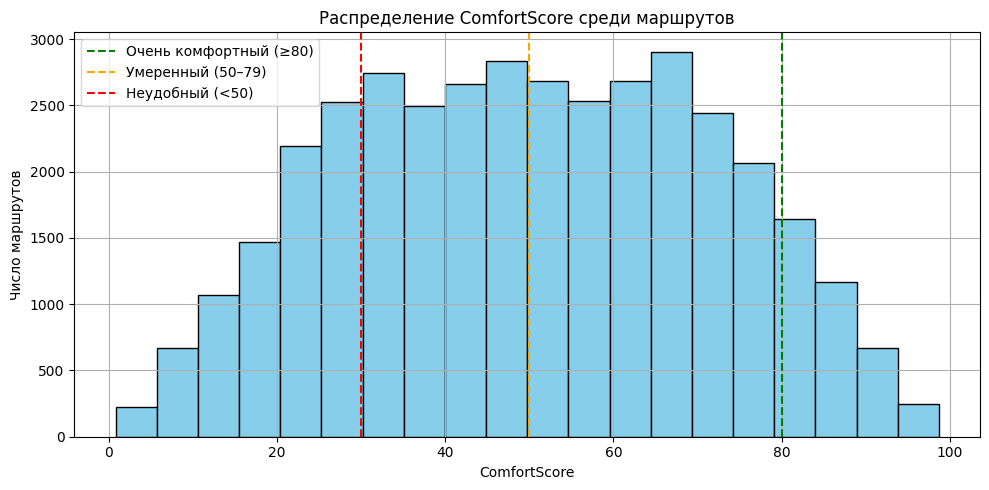

In [28]:
### Распределение маршрутов по ComfortScore:
import matplotlib.pyplot as plt
import numpy as np

# Гистограмма
plt.figure(figsize=(10, 5))
plt.hist(RouteRange['ComfortScore'], bins=20, color='skyblue', edgecolor='black')
plt.axvline(80, color='green', linestyle='--', label='Очень комфортный (≥80)')
plt.axvline(50, color='orange', linestyle='--', label='Умеренный (50–79)')
plt.axvline(30, color='red', linestyle='--', label='Неудобный (<50)')
plt.title('Распределение ComfortScore среди маршрутов')
plt.xlabel('ComfortScore')
plt.ylabel('Число маршрутов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [29]:
# Убедимся, что ComfortScore появился у всех маршрутов, а то были неприятные ошибки
RouteRange[RouteRange['ComfortScore'].isna()]['Concerts'].value_counts().sort_index()

Series([], Name: count, dtype: int64)

In [30]:
RouteRange[RouteRange['ComfortScore'] == 0]

,Sostav,Days,Concerts,Halls,Genre,ShowTime,TransTime,WaitTime,Costs,Musician,...,WaitTime_Score,Trans-Wait_%,Density,HallChanges,Top5Authors,Top5AuthorsShare,RareAuthorsShare,RecommendedArtistsRatio,RecommendedPiecesRatio,ComfortScore


In [31]:
# Функция для меток комфортности маршрута
def label_comfort(score):
    if score >= 80:
        return '🟢 Очень комфортный'
    elif score >= 50:
        return '🟡 Умеренный'
    else:
        return '🔴 Неудобный'

RouteRange['ComfortLevel'] = RouteRange['ComfortScore'].apply(label_comfort)
RouteRange['ComfortLevel'].value_counts()

ComfortLevel
🔴 Неудобный           19071
🟡 Умеренный           15491
🟢 Очень комфортный     3384
Name: count, dtype: int64

### 📚 IntellectScore — Метрика интеллектуальной насыщенности маршрута

**IntellectScore** — это метрика, которая показывает, насколько культурно ценный, разнообразный и необычный маршрут перед вами.

Она объединяет в себе:

* разнообразие жанров и авторов,

* наличие «золотого канона» — ТОП-5 композиторов,

* редкие и уникальные произведения,

* рекомендованных исполнителей и сочинения,

* глубину восприятия (мало произведений → больше времени на каждое).

---

#### 🔢 Формула:
IntellectScore =
w₁ × GenreDiversityScore +
w₂ × Top5AuthorsShare +
w₃ × RareAuthorsShare +
w₄ × RecommendedPiecesRatio +
w₅ × RecommendedArtistsRatio +
w₆ × DepthScore


(все компоненты приведены к шкале от 0 до 100)

---

#### 🧩 Компоненты:

| Метрика                   | Что измеряет                                       |
|---------------------------|----------------------------------------------------|
| `GenreDiversityScore`     | Насколько жанрово разнообразны концерты маршрута   |
| `Top5AuthorsShare`        | Доля произведений от 5 самых популярных авторов    |
| `RareAuthorsShare`        | Доля произведений от редких/малоисполняемых авторов |
| `RecommendedPiecesRatio`  | Доля рекомендованных сочинений                    |
| `RecommendedArtistsRatio` | Доля концертов с рекомендованными исполнителями    |
| `DepthScore`              | Глубина: чем меньше произведений на концерт, тем выше балл |

---

#### 🧠 Интерпретация:

| IntellectScore | Оценка                            | Интерпретация                                         |
|----------------|-----------------------------------|--------------------------------------------------------|
| **80–100**     | 🧠 Интеллектуально насыщенный       | Богатый, сбалансированный маршрут, раскрывающий как классику, так и открытия |
| **60–79**      | 🧠 Интересный, с акцентом           | Есть уникальные или сильные стороны                   |
| **40–59**      | ⚖️ Нейтральный / базовый            | Содержательный, но без редких событий                 |
| **< 40**       | 💤 Поверхностный / шаблонный        | Повторяющиеся темы, мало уникального контента         |


---

#### ⚙️ Настройка весов:

Параметры `genre_weight`, `top_weight`, `rare_weight` и т.д. позволяют адаптировать формулу под цели:

- для широкой аудитории → больше вес популярным авторам
- для знатоков → больше вес редкостям и глубине

---




In [32]:
def apply_quantile_normalization(df: pd.DataFrame, columns: list) -> pd.DataFrame:
    """
    Преобразует указанные колонки в квантильные ранги (от 0 до 1) и возвращает новый DataFrame.
    """
    for col in columns:
        if col in df.columns:
            norm_col = f"{col}_qnorm"
            df[norm_col] = df[col].rank(method='average', pct=True).fillna(0)
    return df


def add_intellect_score_quantile(RouteRange: pd.DataFrame) -> pd.DataFrame:
    """
    Добавляет колонку IntellectScore с квантильной нормализацией редких и рекомендованных признаков.
    """

    # Квантильная нормализация нужных признаков
    norm_cols = ['RareAuthorsShare', 'RecommendedPiecesRatio', 'RecommendedArtistsRatio']
    RouteRange = apply_quantile_normalization(RouteRange, norm_cols)

    # Проверка активности фичей
    use_pieces = 'RecommendedPiecesRatio_qnorm' in RouteRange and RouteRange['RecommendedPiecesRatio'].sum() > 0
    use_artists = 'RecommendedArtistsRatio_qnorm' in RouteRange and RouteRange['RecommendedArtistsRatio'].sum() > 0

    # Базовые веса
    weights = {
        'genre': 0.2,
        'top5': 0.2,
        'rare': 0.2,
        'pieces': 0.2 if use_pieces else 0.0,
        'artists': 0.1 if use_artists else 0.0,
        'depth': 0.1,
    }

    # Нормализуем веса
    total_weight = sum(weights.values())
    for k in weights:
        weights[k] /= total_weight

    # Вспомогательные колонки
    RouteRange['AvgWorksPerConcert'] = RouteRange['programm'] / RouteRange['Concerts']
    RouteRange['DepthScore'] = (1 / RouteRange['AvgWorksPerConcert']).clip(upper=1) * 100
    max_genre = RouteRange['Genre'].max()
    RouteRange['GenreDiversityScore'] = (RouteRange['Genre'] / max_genre * 100).round(1)

    # Итоговый IntellectScore с квантильной нормализацией
    RouteRange['IntellectScore'] = (
        weights['genre'] * RouteRange['GenreDiversityScore'] +
        weights['top5'] * RouteRange['Top5AuthorsShare'] * 100 +
        weights['rare'] * RouteRange['RareAuthorsShare_qnorm'] * 100 +
        weights['pieces'] * RouteRange.get('RecommendedPiecesRatio_qnorm', 0) * 100 +
        weights['artists'] * RouteRange.get('RecommendedArtistsRatio_qnorm', 0) * 100 +
        weights['depth'] * RouteRange['DepthScore']
    ).round(1)

    return RouteRange


In [33]:
RouteRange = add_intellect_score_quantile(RouteRange)
RouteRange.sort_values(by='IntellectScore', ascending=False)

,Sostav,Days,Concerts,Halls,Genre,ShowTime,TransTime,WaitTime,Costs,Musician,...,RecommendedPiecesRatio,ComfortScore,ComfortLevel,RareAuthorsShare_qnorm,RecommendedPiecesRatio_qnorm,RecommendedArtistsRatio_qnorm,AvgWorksPerConcert,DepthScore,GenreDiversityScore,IntellectScore
32436,"[6, 8, 13, 20, 26, 29]",1,6,5,4,355.0,23.0,200.0,1200,11,...,0.0,76.0,🟡 Умеренный,0.960918,0.500013,0.625099,1.333333,75.000000,66.7,74.6
19825,"[6, 8, 13, 20, 29]",1,5,4,4,310.0,14.0,245.0,1000,11,...,0.0,77.6,🟡 Умеренный,0.971591,0.500013,0.548595,1.600000,62.500000,66.7,74.4
20052,"[6, 8, 20, 26, 29]",1,5,5,4,310.0,23.0,245.0,1000,11,...,0.0,51.6,🟡 Умеренный,0.971591,0.500013,0.548595,1.600000,62.500000,66.7,74.4
21046,"[6, 13, 20, 26, 29]",1,5,4,4,310.0,22.0,245.0,1000,10,...,0.0,54.4,🟡 Умеренный,0.980802,0.500013,0.659424,1.200000,83.333333,66.7,74.1
20714,"[6, 11, 18, 26, 29]",1,5,3,4,315.0,16.0,240.0,1000,14,...,0.0,72.1,🟡 Умеренный,0.971591,0.500013,0.521491,1.600000,62.500000,66.7,74.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
349,"[19, 23]",1,2,2,2,90.0,6.0,45.0,400,3,...,0.0,66.7,🟡 Умеренный,0.298437,0.500013,0.040110,6.000000,16.666667,33.3,24.6
38,"[1, 15]",1,2,1,1,90.0,0.0,180.0,400,3,...,0.0,76.7,🟡 Умеренный,0.298437,0.500013,0.040110,7.000000,14.285714,16.7,24.6
2999,"[1, 10, 15, 19]",1,4,3,1,185.0,9.0,145.0,800,6,...,0.0,86.4,🟢 Очень комфортный,0.298437,0.500013,0.147143,6.750000,14.814815,16.7,24.6
27,[28],1,1,1,1,65.0,0.0,0.0,200,1,...,0.0,48.3,🔴 Неудобный,0.298437,0.500013,0.000422,1.000000,100.000000,16.7,24.1


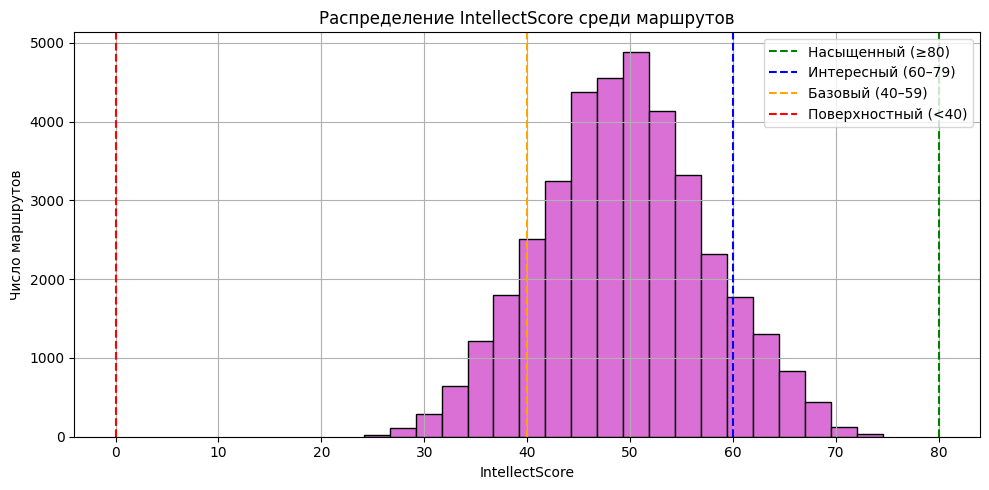

IntellectCategory
⚖️ Базовый         29137
💤 Поверхностный     4695
🎯 Интересный        4114
Name: count, dtype: int64


In [34]:

# Категоризация маршрутов
def interpret_intellect(score):
    if score >= 80:
        return "🧠 Насыщенный"
    elif score >= 60:
        return "🎯 Интересный"
    elif score >= 40:
        return "⚖️ Базовый"
    else:
        return "💤 Поверхностный"

RouteRange['IntellectCategory'] = RouteRange['IntellectScore'].apply(interpret_intellect)

# Построение гистограммы
plt.figure(figsize=(10, 5))
plt.hist(RouteRange['IntellectScore'], bins=20, color='orchid', edgecolor='black')
plt.axvline(80, color='green', linestyle='--', label='Насыщенный (≥80)')
plt.axvline(60, color='blue', linestyle='--', label='Интересный (60–79)')
plt.axvline(40, color='orange', linestyle='--', label='Базовый (40–59)')
plt.axvline(0, color='red', linestyle='--', label='Поверхностный (<40)')
plt.title('Распределение IntellectScore среди маршрутов')
plt.xlabel('IntellectScore')
plt.ylabel('Число маршрутов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Подсчёт количества маршрутов по категориям (опционально)
print(RouteRange['IntellectCategory'].value_counts())


In [35]:
# Метрика интеллектуальной нагруженности периодически получаалась с серьезными перекосами из за неравномерности вклда
# Этот кусок позволяет смотреть на распределение компонент и пытаться вводить другие веса или логшику расчета
RouteRange[['Top5AuthorsShare', 'RareAuthorsShare', 'RecommendedPiecesRatio', 'RecommendedArtistsRatio']].describe()


,Top5AuthorsShare,RareAuthorsShare,RecommendedPiecesRatio,RecommendedArtistsRatio
count,37946.000000,37946.000000,37946.0,37946.000000
mean,0.564251,0.026369,0.0,0.570213
std,0.130507,0.041935,0.0,0.149491
min,0.000000,0.000000,0.0,0.000000
25%,0.469000,0.000000,0.0,0.471000
50%,0.562000,0.000000,0.0,0.556000
75%,0.654000,0.048000,0.0,0.667000
max,1.000000,1.000000,0.0,1.000000


In [36]:
# Логично сделать вывод, что гнатьс яза абсолютными баллами пользователю не интересно, тем более что есть ряд сложно сочетаемых метрик.
# поэтому сделаем нормализацию по квантилям и будем показывать пользователю относительные баллы
def assign_intellect_score_label(df: pd.DataFrame, score_col: str = 'IntellectScore') -> pd.DataFrame:
    """
    Добавляет категорию насыщенности маршрута в колонку 'IntellectScoreLabel'
    на основе квантилей значений score_col.

    Классы:
        - 🧠 Насыщенный (Top 10%)
        - 🎯 Интересный (60–90%)
        - ⚖️ Базовый (30–60%)
        - 💤 Поверхностный (0–30%)
    """
    df['IntellectScoreLabel'] = pd.qcut(
        df[score_col],
        q=[0, 0.3, 0.6, 0.9, 1.0],
        labels=[
            "💤 Поверхностный (0–30%)",
            "⚖️ Базовый (30–60%)",
            "🎯 Интересный (60–90%)",
            "🧠 Насыщенный (Top 10%)"
        ]
    )
    return df

RouteRange = assign_intellect_score_label(RouteRange)

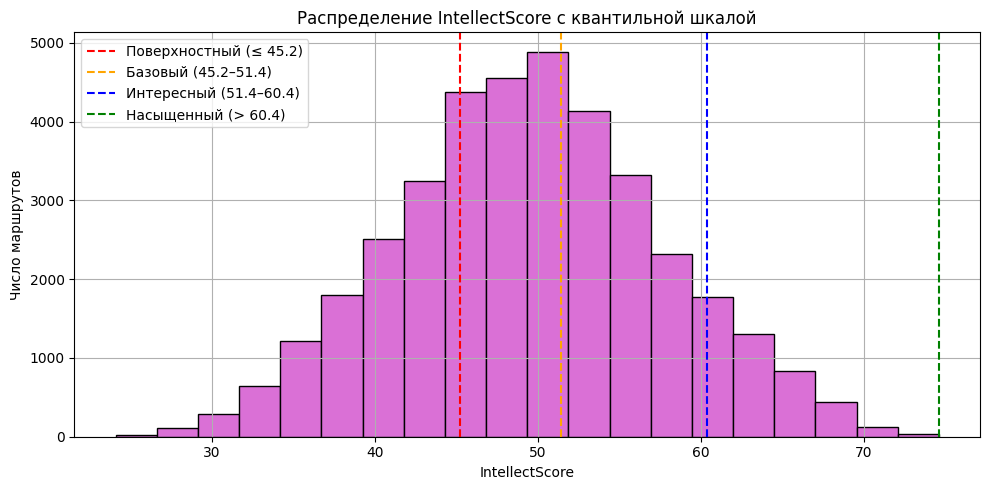

In [37]:
# Гистограмма IntellectScore с квантильными границами
plt.figure(figsize=(10, 5))
plt.hist(RouteRange['IntellectScore'], bins=20, color='orchid', edgecolor='black')

# Квантильные пороги
quantiles = RouteRange['IntellectScore'].quantile([0.3, 0.6, 0.9])
q30, q60, q90 = quantiles[0.3], quantiles[0.6], quantiles[0.9]

# Вертикальные линии и подписи
plt.axvline(q30, color='red', linestyle='--', label=f'Поверхностный (≤ {q30:.1f})')
plt.axvline(q60, color='orange', linestyle='--', label=f'Базовый ({q30:.1f}–{q60:.1f})')
plt.axvline(q90, color='blue', linestyle='--', label=f'Интересный ({q60:.1f}–{q90:.1f})')
plt.axvline(RouteRange['IntellectScore'].max(), color='green', linestyle='--', label=f'Насыщенный (> {q90:.1f})')

# Оформление
plt.title('Распределение IntellectScore с квантильной шкалой')
plt.xlabel('IntellectScore')
plt.ylabel('Число маршрутов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


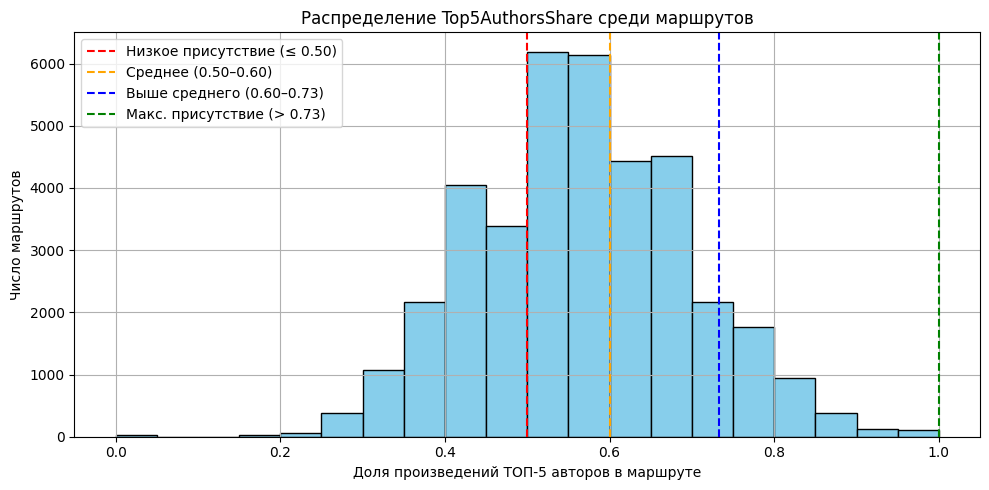

In [38]:
# Гистограмма Top5AuthorsShare с квантильными границами
plt.figure(figsize=(10, 5))
plt.hist(RouteRange['Top5AuthorsShare'], bins=20, color='skyblue', edgecolor='black')

# Квантильные пороги
quantiles_top5 = RouteRange['Top5AuthorsShare'].quantile([0.3, 0.6, 0.9])
q30, q60, q90 = quantiles_top5[0.3], quantiles_top5[0.6], quantiles_top5[0.9]

# Вертикальные линии и подписи
plt.axvline(q30, color='red', linestyle='--', label=f'Низкое присутствие (≤ {q30:.2f})')
plt.axvline(q60, color='orange', linestyle='--', label=f'Среднее ({q30:.2f}–{q60:.2f})')
plt.axvline(q90, color='blue', linestyle='--', label=f'Выше среднего ({q60:.2f}–{q90:.2f})')
plt.axvline(RouteRange['Top5AuthorsShare'].max(), color='green', linestyle='--', label=f'Макс. присутствие (> {q90:.2f})')

# Оформление
plt.title('Распределение Top5AuthorsShare среди маршрутов')
plt.xlabel('Доля произведений ТОП-5 авторов в маршруте')
plt.ylabel('Число маршрутов')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


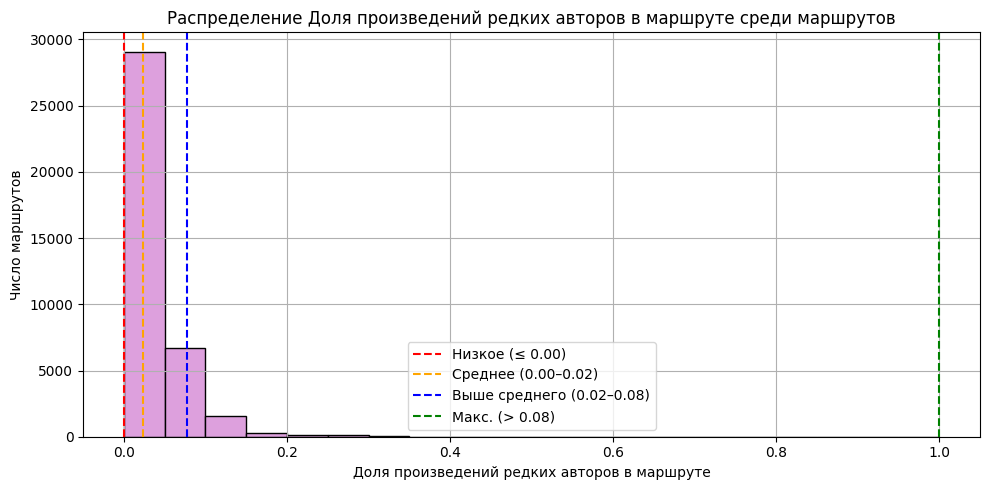

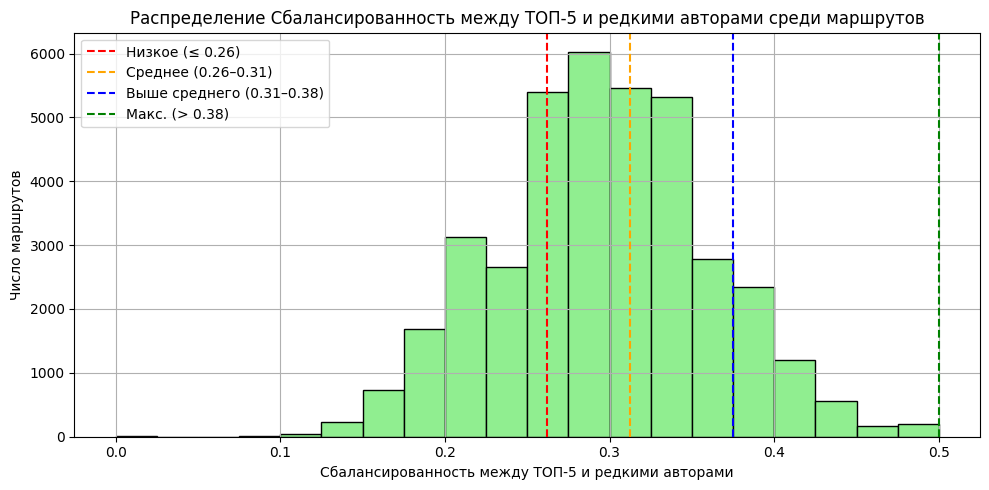

In [39]:
def plot_quantile_histogram(column_name, label, color, df):
    plt.figure(figsize=(10, 5))
    plt.hist(df[column_name], bins=20, color=color, edgecolor='black')

    # Квантильные пороги
    quantiles = df[column_name].quantile([0.3, 0.6, 0.9])
    q30, q60, q90 = quantiles[0.3], quantiles[0.6], quantiles[0.9]

    # Вертикальные границы
    plt.axvline(q30, color='red', linestyle='--', label=f'Низкое (≤ {q30:.2f})')
    plt.axvline(q60, color='orange', linestyle='--', label=f'Среднее ({q30:.2f}–{q60:.2f})')
    plt.axvline(q90, color='blue', linestyle='--', label=f'Выше среднего ({q60:.2f}–{q90:.2f})')
    plt.axvline(df[column_name].max(), color='green', linestyle='--', label=f'Макс. (> {q90:.2f})')

    # Оформление
    plt.title(f'Распределение {label} среди маршрутов')
    plt.xlabel(label)
    plt.ylabel('Число маршрутов')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Построим график для RareAuthorsShare
plot_quantile_histogram(
    column_name='RareAuthorsShare',
    label='Доля произведений редких авторов в маршруте',
    color='plum',
    df=RouteRange
)

RouteRange['AuthorBalance'] = 0.5 * (
    RouteRange['Top5AuthorsShare'].fillna(0) +
    RouteRange['RareAuthorsShare'].fillna(0)
)


# Построим график для AuthorBalance
plot_quantile_histogram(
    column_name='AuthorBalance',
    label='Сбалансированность между ТОП-5 и редкими авторами',
    color='lightgreen',
    df=RouteRange
)


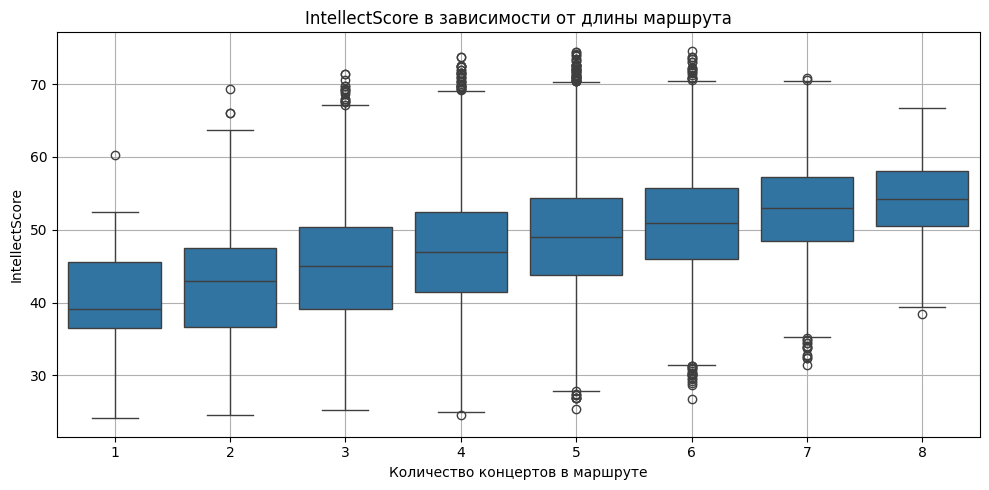

In [40]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.boxplot(x='Concerts', y='IntellectScore', data=RouteRange)
plt.title('IntellectScore в зависимости от длины маршрута')
plt.xlabel('Количество концертов в маршруте')
plt.ylabel('IntellectScore')
plt.grid(True)
plt.tight_layout()
plt.show()


/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/2873855204.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.lineplot(


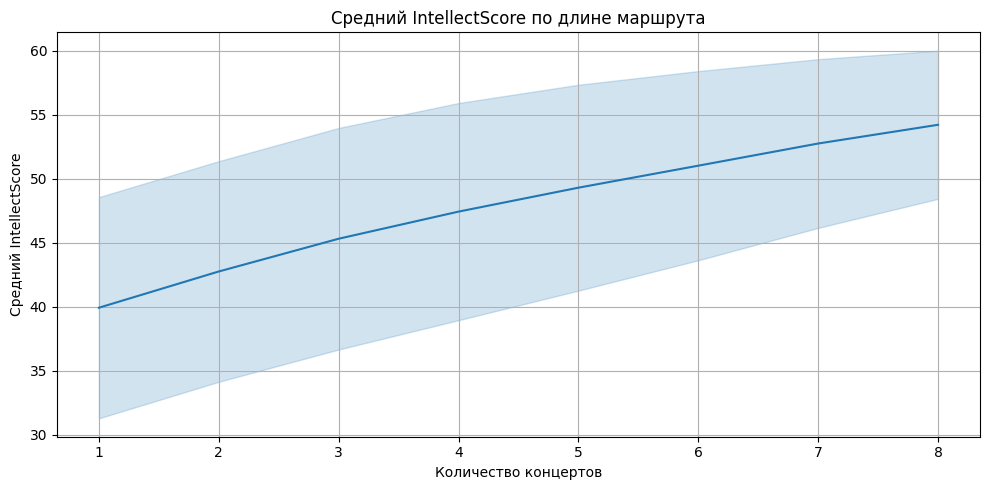

In [41]:
plt.figure(figsize=(10, 5))
sns.lineplot(
    data=RouteRange, x='Concerts', y='IntellectScore',
    ci='sd', estimator='mean'
)
plt.title('Средний IntellectScore по длине маршрута')
plt.xlabel('Количество концертов')
plt.ylabel('Средний IntellectScore')
plt.grid(True)
plt.tight_layout()
plt.show()


In [42]:
def assign_groupwise_intellect_labels(df: pd.DataFrame, score_col='IntellectScore') -> pd.DataFrame:
    """
    Присваивает IntellectScoreLabel на основе квантилей отдельно внутри каждой длины маршрута.
    """
    label_col = f'{score_col}Label'
    df[label_col] = None

    # Определим категории
    labels = [
        "💤 Поверхностный (0–30%)",
        "⚖️ Базовый (30–60%)",
        "🎯 Интересный (60–90%)",
        "🧠 Насыщенный (Top 10%)"
    ]

    # Применим qcut внутри каждой группы по длине маршрута
    for group_value, group_df in df.groupby('Concerts'):
        try:
            cuts = pd.qcut(group_df[score_col], q=[0, 0.3, 0.6, 0.9, 1.0], labels=labels)
            df.loc[group_df.index, label_col] = cuts
        except ValueError:
            # Слишком мало данных в группе — пропускаем
            df.loc[group_df.index, label_col] = None

    return df

RouteRange = assign_groupwise_intellect_labels(RouteRange)


/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4132916527.py:15: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4132916527.py:15: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from current font.
  plt.tight_layout()
/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4132916527.py:15: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/Users/georgijmamarin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/georgijmamarin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/georgijmamarin/Library/Python/3.10/lib/pytho

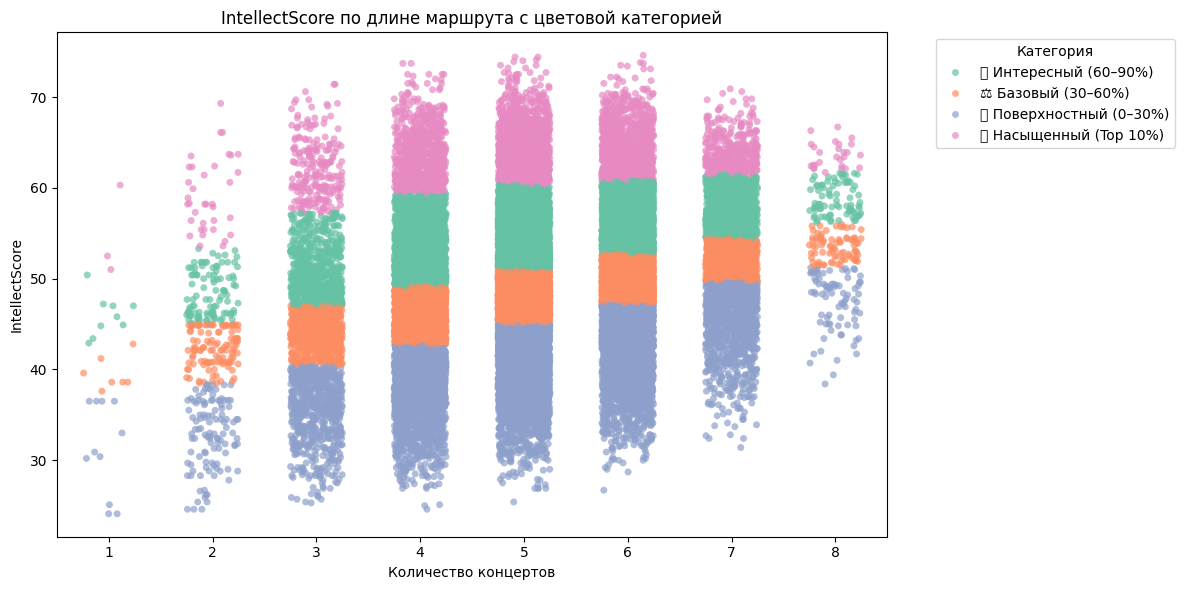

In [43]:
plt.figure(figsize=(12, 6))
sns.stripplot(
    data=RouteRange,
    x='Concerts',
    y='IntellectScore',
    hue='IntellectScoreLabel',
    jitter=0.25,
    palette='Set2',
    alpha=0.7
)
plt.title('IntellectScore по длине маршрута с цветовой категорией')
plt.xlabel('Количество концертов')
plt.ylabel('IntellectScore')
plt.legend(title='Категория', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [44]:
def assign_groupwise_labels(df: pd.DataFrame, score_col: str) -> pd.DataFrame:
    """
    Присваивает категориальные метки на основе квантилей по каждой длине маршрута (Concerts),
    устойчиво к NaN и одинаковым значениям.
    """
    label_col = f'{score_col}Label'
    df[label_col] = None

    labels = [
        "💤 Поверхностный (0–30%)",
        "⚖️ Базовый (30–60%)",
        "🎯 Интересный (60–90%)",
        "🧠 Насыщенный (Top 10%)"
    ]

    for group_value, group_df in df.groupby('Concerts'):
        col = group_df[score_col].dropna()
        if len(col.unique()) >= 4:
            try:
                cuts = pd.qcut(col, q=[0, 0.3, 0.6, 0.9, 1.0], labels=labels, duplicates='drop')
                df.loc[cuts.index, label_col] = cuts
            except Exception:
                df.loc[group_df.index, label_col] = np.NaN
        else:
            df.loc[group_df.index, label_col] = "Недостаточно данных"

    return df


for score_col in ['ComfortScore', 'AuthorBalance', 'Top5AuthorsShare', 'RareAuthorsShare']:
    if score_col in RouteRange.columns:
        RouteRange = assign_groupwise_labels(RouteRange, score_col)


In [45]:
def plot_score_with_labels(df, score_col):
    """
    Строит stripplot для заданной метрики с категоризацией по длине маршрута.
    """
    label_col = f"{score_col}Label"
    if score_col not in df.columns or label_col not in df.columns:
        print(f"Колонки {score_col} или {label_col} не найдены.")
        return

    plt.figure(figsize=(12, 6))
    sns.stripplot(
        data=df,
        x='Concerts',
        y=score_col,
        hue=label_col,
        jitter=0.25,
        palette='Set2',
        alpha=0.7,
        dodge=True
    )
    plt.title(f'{score_col} по длине маршрута с категорией')
    plt.xlabel('Количество концертов')
    plt.ylabel(score_col)
    plt.legend(title='Категория', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


In [46]:
def plot_score_with_labels(df, score_col):
    """
    Строит stripplot для заданной метрики с категоризацией по длине маршрута.
    Игнорирует некорректные или отсутствующие лейблы.
    """
    label_col = f"{score_col}Label"
    
    # Удалим плохие значения
    valid_df = df[df[label_col].isin([
        "💤 Поверхностный (0–30%)",
        "⚖️ Базовый (30–60%)",
        "🎯 Интересный (60–90%)",
        "🧠 Насыщенный (Top 10%)"
    ])].copy()
    
    # Обеспечим порядок категорий
    cat_type = pd.CategoricalDtype([
        "💤 Поверхностный (0–30%)",
        "⚖️ Базовый (30–60%)",
        "🎯 Интересный (60–90%)",
        "🧠 Насыщенный (Top 10%)"
    ], ordered=True)
    valid_df[label_col] = valid_df[label_col].astype(cat_type)

    # Построение графика
    plt.figure(figsize=(12, 6))
    sns.stripplot(
        data=valid_df,
        x='Concerts',
        y=score_col,
        hue=label_col,
        jitter=0.25,
        palette='Set2',
        alpha=0.7,
        dodge=True
    )
    plt.title(f'{score_col} по длине маршрута с категорией')
    plt.xlabel('Количество концертов')
    plt.ylabel(score_col)
    plt.legend(title='Категория', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()


/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4279313724.py:41: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from current font.
  plt.tight_layout()
/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4279313724.py:41: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4279313724.py:41: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/Users/georgijmamarin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/georgijmamarin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/georgijmamarin/Library/Python/3.10/lib/pytho

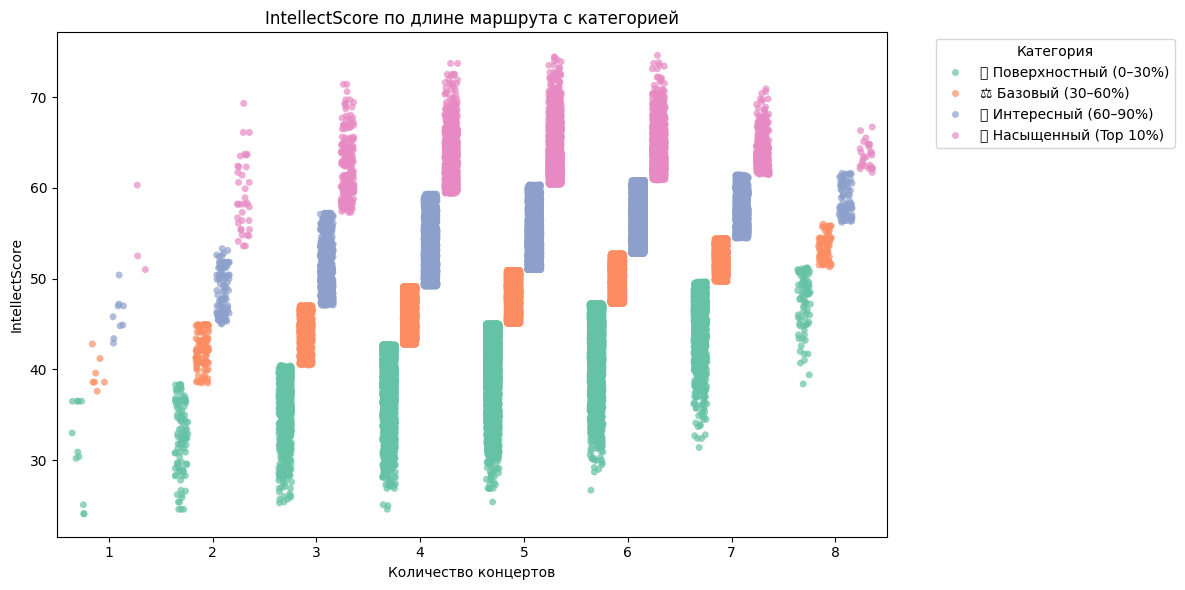

/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4279313724.py:41: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from current font.
  plt.tight_layout()
/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4279313724.py:41: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4279313724.py:41: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/Users/georgijmamarin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/georgijmamarin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/georgijmamarin/Library/Python/3.10/lib/pytho

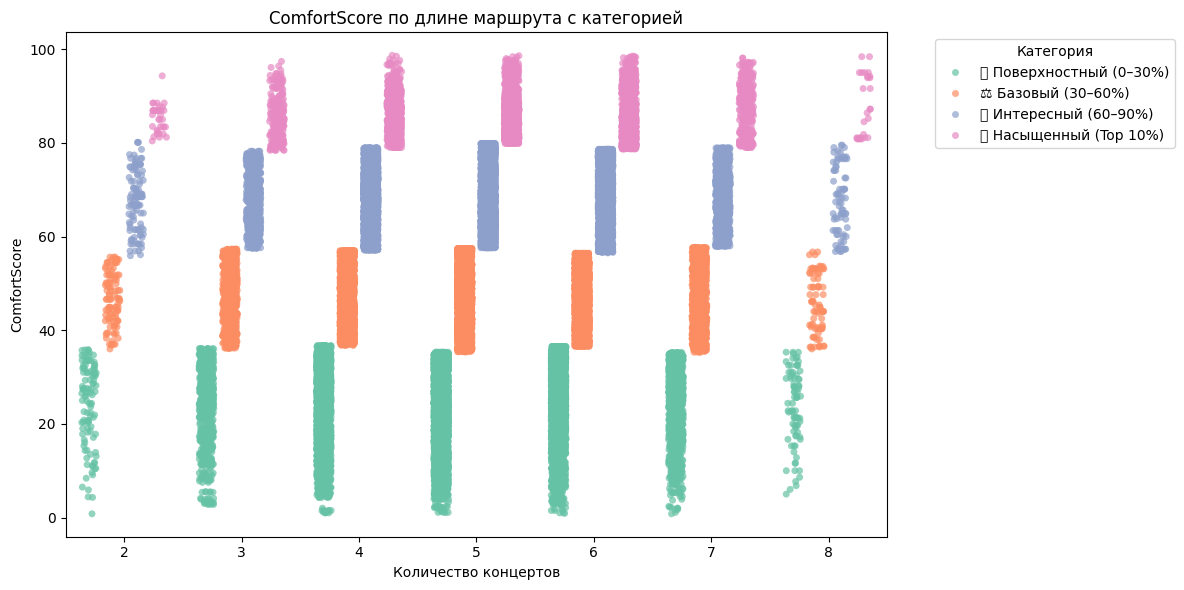

/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4279313724.py:41: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from current font.
  plt.tight_layout()
/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4279313724.py:41: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/4279313724.py:41: UserWarning: Glyph 129504 (\N{BRAIN}) missing from current font.
  plt.tight_layout()
/Users/georgijmamarin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 128164 (\N{SLEEPING SYMBOL}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/georgijmamarin/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:152: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/georgijmamarin/Library/Python/3.10/lib/pytho

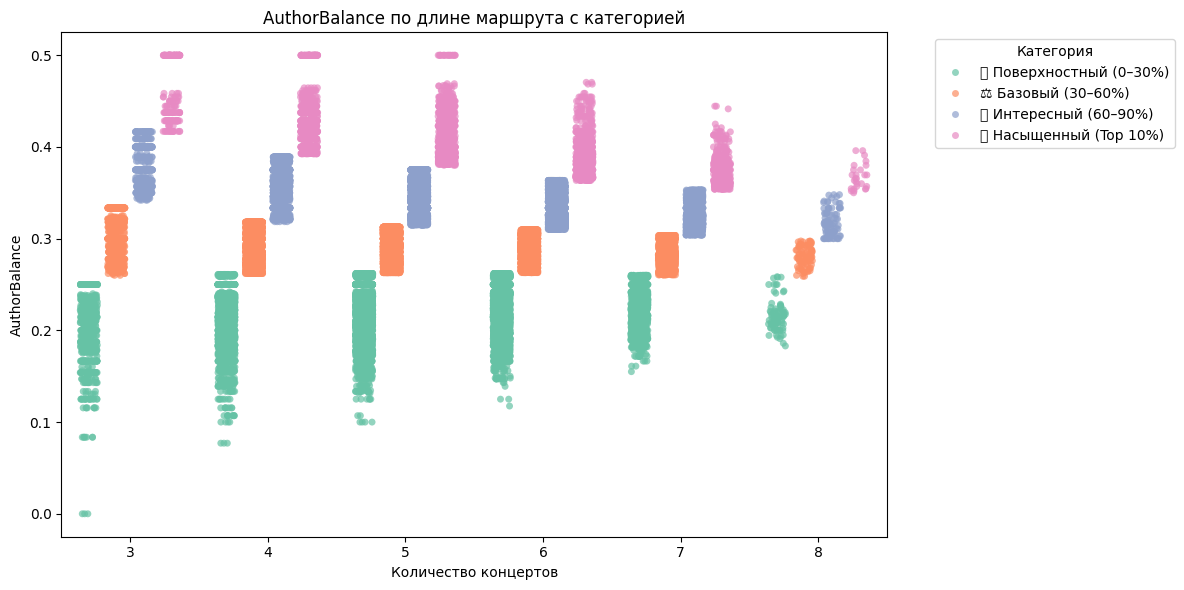

In [47]:
plot_score_with_labels(RouteRange, 'IntellectScore')
plot_score_with_labels(RouteRange, 'ComfortScore')
plot_score_with_labels(RouteRange, 'AuthorBalance')


In [48]:
RouteRange.to_csv("RouteRange.csv", index=False)

In [49]:
RouteRange['TransTime'].value_counts()

TransTime
14.0    1656
15.0    1547
21.0    1532
27.0    1386
28.0    1377
        ... 
73.0       3
74.0       2
75.0       1
71.0       1
69.0       1
Name: count, Length: 76, dtype: int64

# Модели

Когда столько всего размечено так и чешуться руки покрутить какие-нибудь модели. А направления у нас сейчас объективно два:
1. кластеризовать маршруты, чтобы пользователям было легчке ориентироваться в выдаче
2. подобрать первичную анкету для скрининга интересов пользователя, и на основе этих данных прогнозировать подходящий маршрут или дополнить существующий

## 1. Кластеризация маршрутов (unsupervised learning)
**Задача:** Найти схожие группы маршрутов — тематические кластеры, маршруты "для интеллектуалов", "для семей", "короткие, но насыщенные" и пр.

** Вариант реализации:
* Модели: KMeans, DBSCAN, Hierarchical Clustering
* Векторы признаков:
    * нормализованные числовые метрики маршрута
    * PCA или UMAP для снижения размерности перед визуализацией

* Применение:
    * автоматическая категоризация
    * фильтрация и рекомендации на основе типа маршрута

В этом месте будем брать маршруты и сохраненного файла, просто чтобы не пересчитывать весь документ.

/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/2813067585.py:8: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('RouteRange.csv')#.set_index('Unnamed: 0', inplace=True)


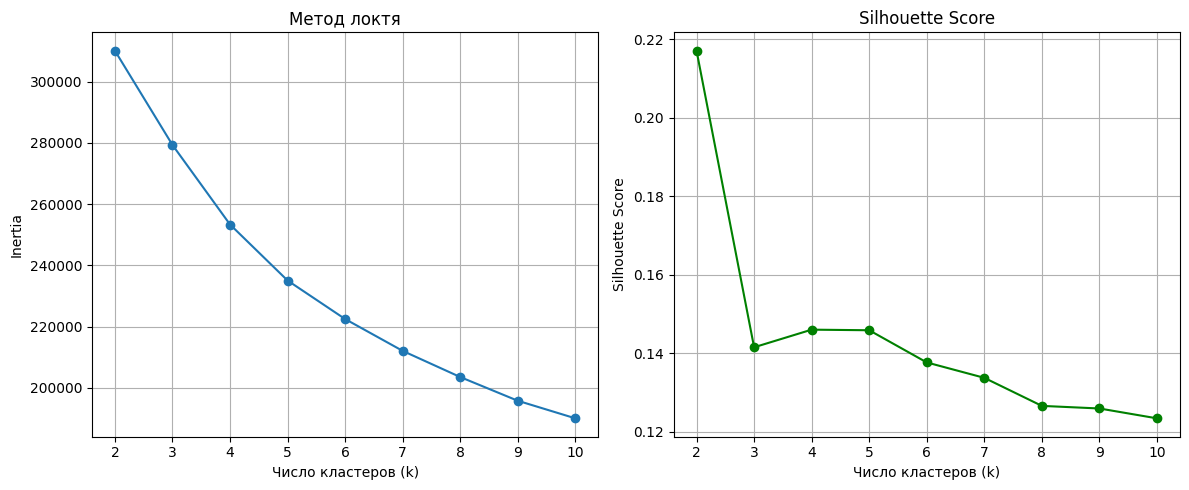

In [50]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Загрузка данных
df = pd.read_csv('RouteRange.csv')#.set_index('Unnamed: 0', inplace=True)

# Отбор признаков
features = [
    'IntellectScore', 'ComfortScore', 'AuthorBalance',
    'Costs', 'Concerts', 'Genre', 'Halls', 'ShowTime',
    'TransTime', 'WaitTime', 'FamilyConc'
]
df_cluster = df[features].dropna().copy()

# Масштабирование
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_cluster)

# Вычисление метрик для разных k
inertias = []
silhouette_scores = []
k_range = range(2, 11)

for k in k_range:
    model = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = model.fit_predict(X_scaled)
    inertias.append(model.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, labels))

# Визуализация метрик
plt.figure(figsize=(12, 5))

# Метод локтя
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, marker='o')
plt.title("Метод локтя")
plt.xlabel("Число кластеров (k)")
plt.ylabel("Inertia")
plt.grid(True)

# Silhouette Score
plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, marker='o', color='green')
plt.title("Silhouette Score")
plt.xlabel("Число кластеров (k)")
plt.ylabel("Silhouette Score")
plt.grid(True)

plt.tight_layout()
plt.show()


**Интерпретация метода локтя**
падает быстро до 4–5 кластеров, затем начинает снижаться гораздо медленнее.
Это говорит о "локте" около k = 4 или k = 5 — после этой точки добавление новых кластеров даёт всё меньший выигрыш в компактности.

**Интерпретация Silhouette Score**
Наилучший силуэт достигается при k = 2 (около 0.22), после чего наблюдается резкое падение.
Начиная с k ≥ 3 все значения — в диапазоне 0.12–0.15, без явных максимумов.

Метод локтя	4–5	Компромисс между простотой и качеством
Silhouette Score	2	Формально лучший, но может быть слишком грубым

Кажется, что разумным компромиссом будет k = 4, так как:
* он находится в области "локтя";
* даёт ещё достаточно различимые кластеры;
* позволяет сохранить интерпретируемую структуру (например: "семейные", "интеллектуальные", "комфортные", "разнообразные").


Честно говоря, мысль тут надо еще покрутить, потому что маршрутов ооочень много, и классы непредсказуемы. Нужно бы еще поисследовать.

In [51]:
# Кластеризация
k = 4
kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
df_cluster['Cluster'] = kmeans.fit_predict(X_scaled)

# PCA для визуализации
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Визуализация кластеров
plt.figure(figsize=(10, 6))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=df_cluster['Cluster'], cmap='tab10', alpha=0.6)
plt.title("Кластеры маршрутов (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.colorbar(scatter, label='Кластер')
plt.tight_layout()
plt.show()

# Средние значения характеристик по каждому кластеру
cluster_summary = df_cluster.groupby('Cluster')[features].mean().round(1)
print(cluster_summary)


NameError: name 'PCA' is not defined

### Другой метод кластеризации

In [ ]:
#%pip install hdbscan

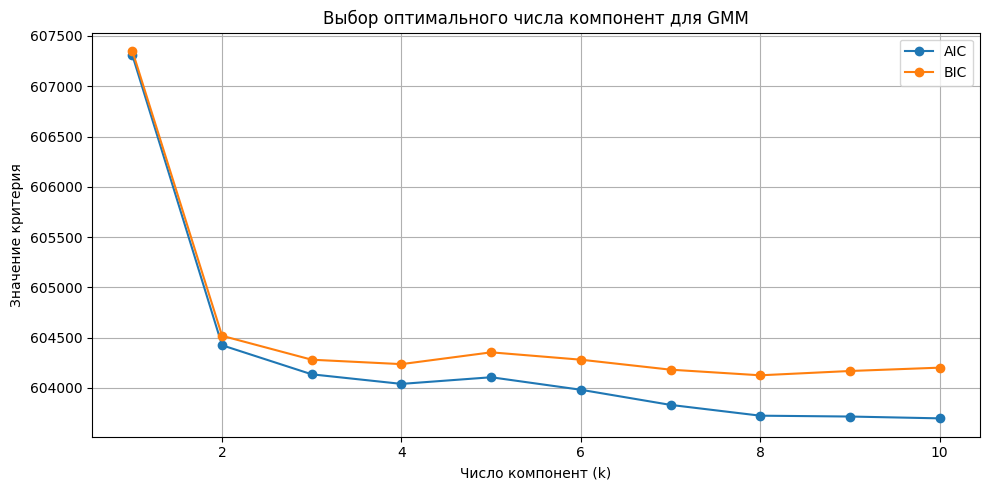

In [52]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture

X = df[['ComfortScore', 'IntellectScore']].dropna()

aic = []
bic = []
ks = range(1, 11)  # Пробуем от 1 до 10 компонент

for k in ks:
    gmm = GaussianMixture(n_components=k, random_state=42)
    gmm.fit(X)
    aic.append(gmm.aic(X))
    bic.append(gmm.bic(X))

# Визуализация
plt.figure(figsize=(10, 5))
plt.plot(ks, aic, label='AIC', marker='o')
plt.plot(ks, bic, label='BIC', marker='o')
plt.xlabel('Число компонент (k)')
plt.ylabel('Значение критерия')
plt.title('Выбор оптимального числа компонент для GMM')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


Обе кривые (AIC и BIC) резко падают от 1 до 2 компонент, а затем стабилизируются.

BIC достигает минимума при 4 компонентах, а затем начинает медленно расти.

AIC продолжает немного снижаться до 10 компонент, но очень медленно, что указывает на переобучение при большем количестве.

птимальное число компонент для GMM — 4 или 5, в зависимости от того, что считать важнее:
* Более строгая модель	BIC	n_components = 4
* Более гибкая, допускающая лёгкое переобучение	AIC	n_components = 5

/var/folders/ph/7m0lcx1d1_q_2b1f5fzxch7m0000gn/T/ipykernel_61998/910723592.py:8: DtypeWarning: Columns (40) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('RouteRange.csv')


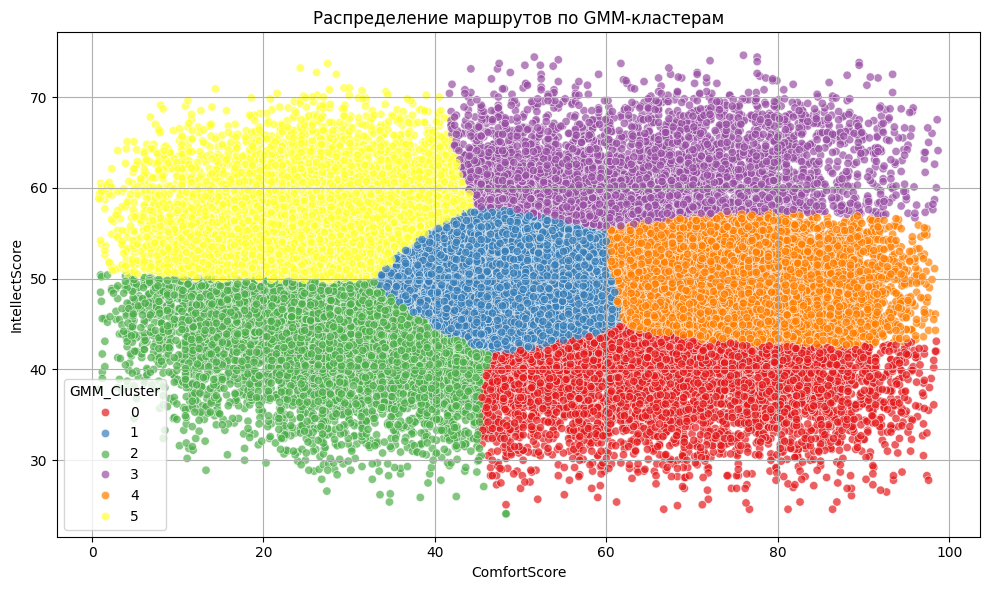

In [60]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler
import seaborn as sns

# Загрузи данные, если еще не загружены
df = pd.read_csv('RouteRange.csv')

# Отбираем только нужные колонки
features = ['ComfortScore', 'IntellectScore']
X = df[features].dropna()

# Стандартизация данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Обучение GMM
n_components = 6  # Можно варьировать
gmm = GaussianMixture(n_components=n_components, random_state=42)
clusters = gmm.fit_predict(X_scaled)
df['GMM_Cluster'] = gmm.fit_predict(X)


# Добавим к результатам
df.loc[X.index, 'GMM_Cluster'] = clusters

# Визуализация
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df.loc[X.index],
    x='ComfortScore',
    y='IntellectScore',
    hue='GMM_Cluster',
    palette='Set1',
    alpha=0.7,
    edgecolor='white'
)
plt.title('Распределение маршрутов по GMM-кластерам')
plt.grid(True)
plt.tight_layout()
plt.show()


In [61]:
df.to_csv('RouteRange_with_GMM.csv', index=False)

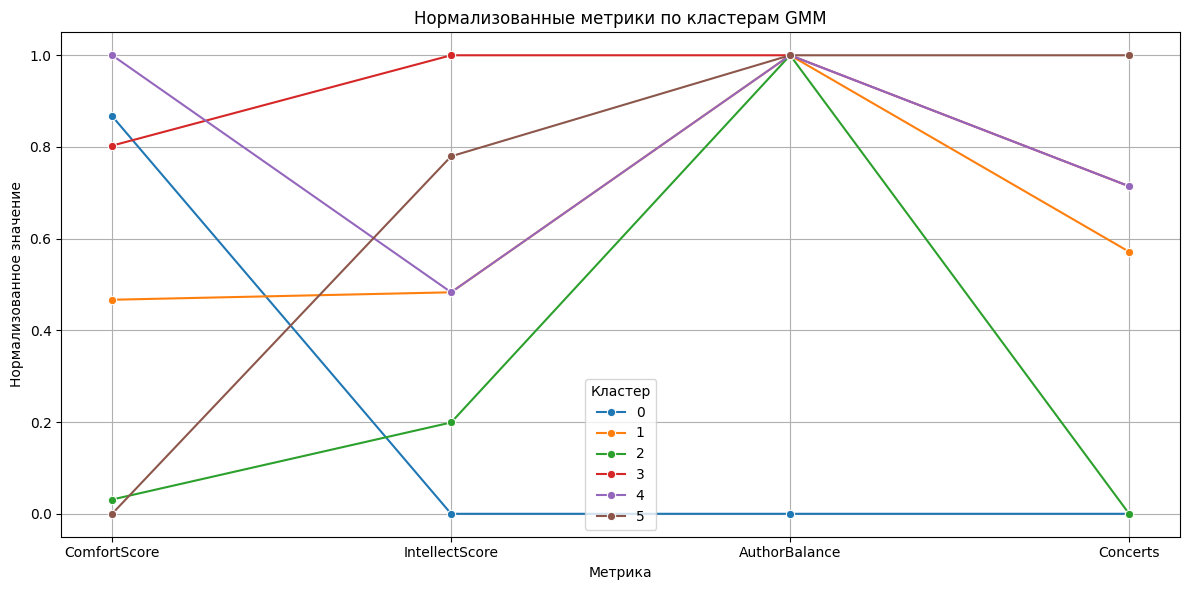

In [62]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler

# Загрузка таблицы
# Группировка по кластерам и расчет метрик
cluster_stats = df.groupby("GMM_Cluster")[["ComfortScore", "IntellectScore", "AuthorBalance", "Concerts"]].mean().round(1)

# Нормализация для визуализации
scaler = MinMaxScaler()
cluster_stats_scaled = pd.DataFrame(
    scaler.fit_transform(cluster_stats),
    columns=cluster_stats.columns,
    index=cluster_stats.index
).reset_index()

# Подготовка данных для графика
cluster_melted = cluster_stats_scaled.melt(id_vars="GMM_Cluster", var_name="Metric", value_name="Score")

# Построение графика
plt.figure(figsize=(12, 6))
sns.lineplot(data=cluster_melted, x="Metric", y="Score", hue="GMM_Cluster", marker="o", palette="tab10")
plt.title("Нормализованные метрики по кластерам GMM")
plt.ylabel("Нормализованное значение")
plt.xlabel("Метрика")
plt.legend(title="Кластер")
plt.grid(True)
plt.tight_layout()
plt.show()


In [65]:
# Рассчитываем средние значения по кластерам
cluster_summary = df.groupby("GMM_Cluster")[["ComfortScore", "IntellectScore", "AuthorBalance", "Concerts"]].mean().round(1)

# Добавим интерпретации вручную
interpretations = {
    0: "Комфортный, но интеллектуально простой",
    1: "Средние значения по всем метрикам",
    2: "Низкий комфорт, умеренный интеллект",
    3: "Очень интеллектуально насыщенный",
    4: "Очень комфортный, со средней насыщенностью",
    5: "Максимальная насыщенность, но некомфортно"
}

cluster_summary["Интерпретация"] = cluster_summary.index.map(interpretations)

# Сброс индекса и вывод
cluster_summary = cluster_summary.reset_index()
print(cluster_summary)


   GMM_Cluster  ComfortScore  IntellectScore  AuthorBalance  Concerts  \
0            0          67.6            38.3            0.2       4.8   
1            1          48.3            49.7            0.3       5.2   
2            2          27.3            43.0            0.3       4.8   
3            3          64.5            61.9            0.3       5.3   
4            4          74.0            49.7            0.3       5.3   
5            5          25.8            56.7            0.3       5.5   

                                Интерпретация  
0      Комфортный, но интеллектуально простой  
1           Средние значения по всем метрикам  
2         Низкий комфорт, умеренный интеллект  
3            Очень интеллектуально насыщенный  
4  Очень комфортный, со средней насыщенностью  
5   Максимальная насыщенность, но некомфортно  


## 2. Модель ранжирования маршрутов по предпочтениям пользователя (recommender / ranking)


Руки дойдут до этого не то чтобы прям скоро, но хочу сделать набросок тезисов, чтобы потом не забыть. 

**Задача:**
Научиться предсказывать, какие маршруты больше понравятся пользователю, на основе его выбора, интересов, ограничений (уже купленных концертов).

**Пример реализации:**
* Тип модели: Gradient Boosting (LightGBM, CatBoost), Neural Network или Learning to Rank (например, XGBoost rank:pairwise)

* Признаки (features): 
    * IntellectScore, ComfortScore, AuthorBalance, 
    * Длина маршрута, стоимость, уникальность залов, количество семейных концертов и т.п.
    * Жанровое разнообразие, топ-авторы, доля рекомендаций

* Целевая переменная:
    * Оценка пользователя (like/dislike, рейтинг от 1 до 5 и т.д.)
    * Или бинарный флаг — выбрал маршрут или нет



In [ ]:
## 1